## Simulate time series using fitted ARIMA model:

### Using sktime and statsforecast

In [ ]:
#-----------------IMPORTS-----------------#
from numba import njit
import pandas as pd #we separately import pandas to read data from a csv file
import numpy as np

#-----------------DATA-----------------#
#1min EURGBP data
url = "https://onedrive.live.com/download?resid=4E16D53638D067A9%21339325&authkey=!AHOCBUokDjDiCc8"

#1 second EURGBP data
#url = "https://onedrive.live.com/download?resid=4E16D53638D067A9%21339754&authkey=!ACcJZZPFqOmKVUY"

data_downloaded = pd.read_csv(url, parse_dates = True, index_col=0) #it's a time series data, so I'm setting the index to be the first column
data_downloaded = data_downloaded.asfreq('T')
data_downloaded.ffill(inplace=True)
print(data_downloaded.index.freq)
#close = data_downloaded["close"].to_numpy() #We transform the close prices into a numpy array

In [ ]:
### Fit using sktime
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(stepwise=False, n_jobs=-1, start_p=0, start_q=0, max_p=10, max_q=10, seasonal=False)
forecaster.fit(data_downloaded["close"])
forecaster.get_fitted_params()

In [ ]:
### Fitted SARIMA parameters:
{'intercept': -5.398901140173307e-08,
 'ma.L1': -0.1042188993634203,
 'ma.L2': -0.029764115450367442,
 'ma.L3': -0.002917953581047072,
 'ma.L4': 0.004290940137585559,
 'ma.L5': -0.012028812812397361,
 'sigma2': 2.956406656496939e-09,
 'order': (0, 1, 5),
 'seasonal_order': (0, 0, 0, 0),
 'aic': -5639035.469712176,
 'aicc': -5639035.469378472,
 'bic': -5638960.403255404,
 'hqic': -5639013.861095114}

### Make a simulator that optimizes the BB strategy based on simulated price paths obtained from fitting an ARIMA model on the close price

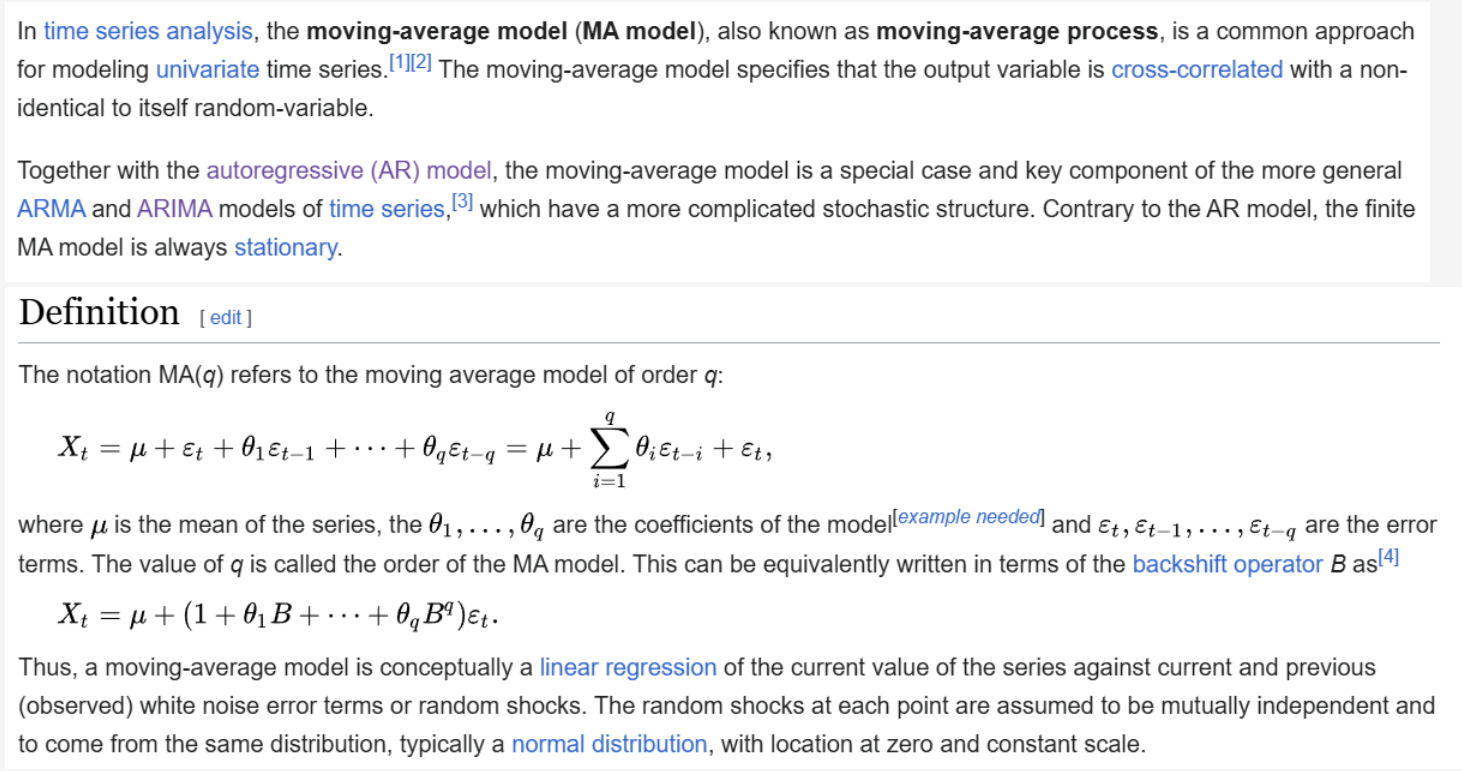

In [ ]:
### Fitted SARIMA parameters:
#####################################################
{'intercept': -5.398901140173307e-08,
 'ma.L1': -0.1042188993634203,
 'ma.L2': -0.029764115450367442,
 'ma.L3': -0.002917953581047072,
 'ma.L4': 0.004290940137585559,
 'ma.L5': -0.012028812812397361,
 'sigma2': 2.956406656496939e-09,
 'order': (0, 1, 5),
 'seasonal_order': (0, 0, 0, 1),
 'aic': -5639035.469712176,
 'aicc': -5639035.469378472,
 'bic': -5638960.403255404,
 'hqic': -5639013.861095114}

In [1]:
import numpy as np
import pandas as pd

#-----------------DATA-----------------#
#1min EURGBP data
url = "https://onedrive.live.com/download?resid=4E16D53638D067A9%21339325&authkey=!AHOCBUokDjDiCc8"

data_downloaded = pd.read_csv(url, parse_dates = True, index_col=0) #it's a time series data, so I'm setting the index to be the first column
close = data_downloaded["close"].to_numpy() #We transform the close prices into a numpy array

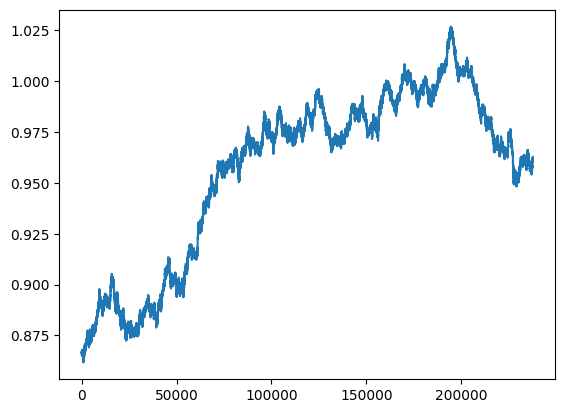

In [11]:
import numpy as np
import pandas as pd
from numba import njit

@njit(fastmath = True) #we use the njit decorator to speed up the function
def GenerateSimulation(data):
    yt = np.zeros(len(data))
    #yt[0] = np.mean(data)
    error_terms = np.zeros(len(data))
    sigma2 = 2.956406656496939e-08
    sigma = np.sqrt(sigma2)
    error_terms[0] = np.random.normal(0, sigma)
    intercept = -5.398901140173307e-08
    
    for i in range(1,len(yt)):
        error_terms[i] = np.random.normal(0, sigma)
        yt[i] = intercept  + error_terms[i] + -0.1042188993634203 * error_terms[i-1] + -0.029764115450367442 * error_terms[i-2] + -0.002917953581047072 * error_terms[i-3] + 0.004290940137585559 * error_terms[i-4] + -0.012028812812397361 * error_terms[i-5]

    return yt

yt = GenerateSimulation(close)
yt[0] = close[0]
simulated_data = np.cumsum(yt)

import matplotlib.pyplot as plt
plt.plot(simulated_data)
plt.show()

In [ ]:
### Now I need to simulate thousands of time series based on that model; I will use the same error terms for all of them
@njit(fastmath = True) #we use the njit decorator to speed up the function
def ThousandSimulations(data, number_simulations):
    simulated_series_matrix = np.zeros((len(data), number_simulations))
    for i in range(number_simulations):
        simulated_series_matrix[:,i] = GenerateSimulation(data)

    return simulated_series_matrix

In [ ]:
### IMPORT THE BB BACKTEST FUNCTION FROM GITHUB:
import requests
url_function = "https://raw.githubusercontent.com/edoardoCame/PythonMiniTutorials/main/trading%20strategies/MyOwnBacktester/RESAMPLING%20optimization%20BBs/main_func.py"
response = requests.get(url_function)
exec(response.text)

In [ ]:
from time import time
from numba import prange
@njit(fastmath = True, parallel=True) #we use the njit decorator to speed up the function
def MonteCarloOptimizer(data, num_simulations, window, num_std_devs, fees_percentage, starting_cash):
    simulated_series = ThousandSimulations(data, num_simulations)
    montecarlo_equities = np.zeros((len(data), num_simulations))
    
    splitter = num_simulations/2 #we split the simulations in two to run them in parallel

    for i in prange(0, int(splitter)):
        montecarlo_equities[:,i] = backtest_bollinger_bands(simulated_series[:,i], window=window, num_std_devs=num_std_devs, fees_percentage=fees_percentage, starting_cash=starting_cash)
        print(f"Simulation {i} completed")


    for i in prange(int(splitter), num_simulations):
        montecarlo_equities[:,i] = backtest_bollinger_bands(simulated_series[:,i], window=window, num_std_devs=num_std_devs, fees_percentage=fees_percentage, starting_cash=starting_cash)
        print(f"Simulation {i} completed")

    return montecarlo_equities

In [ ]:
start = time()
montecarlo_equities = MonteCarloOptimizer(data=close, num_simulations=10000, window=60, num_std_devs=5, fees_percentage=0, starting_cash=100)
print("Time taken with numba: ", time()-start)

last_rows = montecarlo_equities[-1,:]
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.hist(last_rows, bins=30, edgecolor='black', color='yellow')
plt.title('Histogram of the final equities backtested on simulated time series')
plt.xlabel('Final Equity')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.show()